In [9]:
import numpy as np
import scipy.sparse as sparse
from os import listdir

chroms = [str(x) for x in range(22, 23)]
#data_dir = '../split_gen_ihart'
data_dir = '../split_gen_spark'
ped_file = '../data/v34.vcf.ped'

# read samples
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, '10')
with open(sample_file, 'r') as f:
    sample_id_to_index = dict([(line.strip(), i) for i, line in enumerate(f)])

# read family structure
parents = set()
children = set()
with open(ped_file, 'r') as f:
    for line in f:
        fam_id, ind_id, dad_id, mom_id, sex, disease_status = line.strip().split('\t')[:6]
        # sex: 1=male, 2=female
        # disease status: 1=unaffected, 2=affected
        if dad_id != '0' and dad_id in sample_id_to_index:
            parents.add(dad_id)
        if mom_id != '0' and mom_id in sample_id_to_index:
            parents.add(mom_id)
        if (dad_id != '0' or mom_id != '0') and ind_id in sample_id_to_index:
            children.add(ind_id)
        
# only interested in children, not parents
samples_of_interest = sorted(children - parents)
indices = [sample_id_to_index[s] for s in samples_of_interest]
print('Individuals of interest:', len(indices))

all_gen_data = []
all_positions = []
for chrom in chroms:
    print(chrom)
    
    # load genotypes
    gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

    # pull snp positions
    pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
    is_snp = pos_data[:, 2].astype(bool)
    is_pass = pos_data[:, 3].astype(bool)
    snp_positions = pos_data[:, 1]
    print('Sites pulled from vcf:', snp_positions.shape[0])

    # pull PASS (from GATK)
    #is_pass = np.load('%s/chr.%s.pass.npy' % (data_dir, chrom))

    # Pull data together
    A = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[indices, :] for gen_file in gen_files])

    # only look at snps that PASS GATK filter
    A = A[:, is_snp & is_pass]
    snp_positions = snp_positions[is_snp & is_pass]
    print('Removed %d sites that are not bi-allelic SNPs' % np.sum(~is_snp))
    print('Removed %d sites that do not pass GATK' % np.sum(is_snp & ~is_pass))

    # sparse to dense
    A = A.A

    # filter out sites with too many missing values
    missing_cutoff = 0.01
    lots_of_missing_indices = np.sum(A<0, axis=0) > 0.01*len(indices)
    #A = A[:, ~lots_of_missing_indices]
    #snp_positions = snp_positions[~lots_of_missing_indices]
    print('Removed %d sites with >%0.3f missing' % (np.sum(lots_of_missing_indices), missing_cutoff))

    # remove sites where everyone is homref or missing
    has_variants = np.any(A>0, axis=0)
    A = A[:, has_variants]
    snp_positions = snp_positions[has_variants]
    print('Removed %d sites where everyone is hom-ref' % np.sum(~has_variants))

    # remaining missing -> hom ref
    #print('Changed %d calls from missing (-1) to hom-ref (0)' % np.sum(A<0))
    #A[A<0] = 0

    print('Final matrix', A.shape, snp_positions.shape)
    
    all_gen_data.append(A)
    all_positions.append(snp_positions)


Individuals of interest: 2700
22
Sites pulled from vcf: 1096535
Removed 91886 sites that are not bi-allelic SNPs
Removed 70557 sites that do not pass GATK


KeyboardInterrupt: 

In [11]:
gen_files = sorted([f for f in listdir('../split_gen_ihart') if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

A = sparse.hstack([sparse.load_npz('%s/%s' % ('../split_gen_ihart', gen_file))[indices, :] for gen_file in gen_files])
B = sparse.hstack([sparse.load_npz('%s/%s' % ('../split_gen_ihart_new', gen_file))[indices, :] for gen_file in gen_files])


In [12]:
print(A.shape, B.shape)

(2700, 1096535) (2700, 1096535)


In [19]:
print(np.all(A.nnz==B.nnz))

True


In [8]:
print(all_positions[0].shape)

(2965432,)


In [18]:
gen_data = np.hstack(all_gen_data)
positions = np.hstack(all_positions)
print(gen_data.shape, positions.shape)

(931, 432965) (432965,)


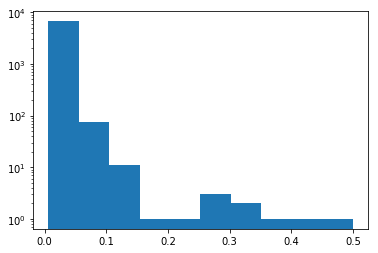

In [13]:
import matplotlib.pyplot as plt

num_missing = np.sum(gen_data<0, axis=1)/gen_data.shape[1]
plt.hist(num_missing, log=True)
plt.show()

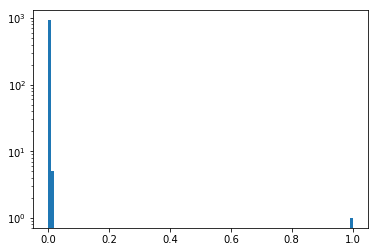

In [21]:
num_missing = np.sum(gen_data<0, axis=1)/gen_data.shape[1]
plt.hist(num_missing, log=True, bins=np.arange(0, 1.01, 0.01))
plt.show()

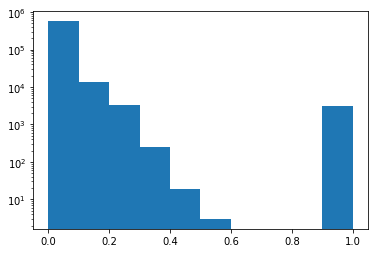

In [14]:
num_missing = np.sum(gen_data<0, axis=0)/gen_data.shape[0]
plt.hist(num_missing, log=True)
plt.show()

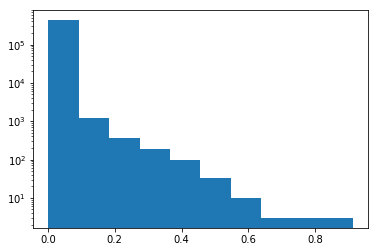

In [20]:
num_missing = np.sum(gen_data<0, axis=0)/gen_data.shape[0]
plt.hist(num_missing, log=True)
plt.show()

In [14]:
with open('../data/OMNI2.5_pruned_positions.txt', 'w+') as outf:
    outf.write('# rsid\tchromosome\tposition\n')
    for chrom in [str(x) for x in range(1, 23)]:
        with open('../../PrunediHART/%s.pruned.bim' % chrom) as f:
            for line in f:
                pieces = line.strip().split('\t')
                outf.write('.\t%s\t%s\n' % (chrom, pieces[3]))
    